In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [1]:
import sys
from collections import Counter, defaultdict
import json

Let analyse a tweet and get the hashtags involed in the tweet

In [2]:
TWEETS_PATH = '../data/query_drc_by_hashtags__03-06-2019-12-53.jsonl'

In [3]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [4]:
def get_text(tag):
    return tag.get('text').lower()

In [5]:
with open(TWEETS_PATH, 'r') as f :
    hastags = Counter()
    for line in f:
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        hastags.update(hashtags_in_tweet)
    for tag,count in hastags.most_common(25):
        print("{} : {}".format(tag, count))

ebola : 71
etwm : 39
kinshasa : 38
chebeya : 22
goma : 20
tshisekedi : 14
bukavu : 13
kabila : 12
sénégal : 11
kindu : 11
bemba : 11
redditodicittadinanza : 11
azzurenature : 10
immorteluc : 8
saintlucnkulula : 8
héroslucnkulula : 8
amourinégal : 8
csp : 7
bcc : 7
mwilambwe : 7
bazana : 7
obsèquesetshisekedi : 6
poranekrdc : 6
floribertchebeya : 6
peing : 6


let check how our people uses others hastags apart from the one I selected 

In [6]:
with open(TWEETS_PATH , 'r') as f :
    hashtag_count = defaultdict(int)
    for line in f :
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        n_of_hashtags = len(hashtags_in_tweet)
        hashtag_count[n_of_hashtags] +=1
        tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
        tweet_without_hashtags = hashtag_count[0]
        total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

1551 tweets without hashtags  (77.55%)
449 tweets with at least one hashtag  (22.45%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [8]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [9]:
tweet_tokenizer = TweetTokenizer()
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les', '-', ]
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [10]:
term_counts = Counter()
with open(TWEETS_PATH, 'r') as f :
    for line in f:
        tweet = json.loads(line)
        tokens = process_text(text=tweet.get('text'), tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    for tag, count in term_counts.most_common(20):
        print("{}: {}".format(tag, count))

#rdc: 702
’: 679
rdc: 368
kinshasa: 349
juin: 264
retour: 251
annonce: 229
@bembajp: 223
dimanche: 213
chers: 205
compatriotes: 201
joie: 201
enthousiasme: 201
tshisekedi: 167
président: 90
@presidence_rdc: 77
drc: 76
@fabienkalalacim: 74
@stanysbujakera: 72
#ebola: 71


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [11]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

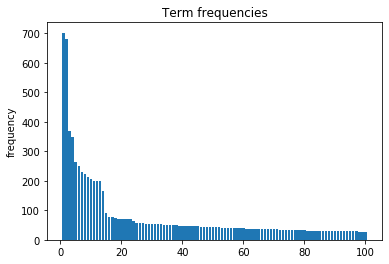

In [12]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [13]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [14]:
def read_tweets_file(path):
    """
    a genrator function which read a json file of tweets and return a iterator of this content file by line
    param:
    path : json file path
    """
    with open(path, 'r') as f :
        for line in f:
            tweet = json.loads(line)
            yield tweet

In [15]:
all_dates = list()
for tweet in read_tweets_file(TWEETS_PATH):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [16]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

2019-06-03 10:52:52+00:00 2019-06-03 07:23:28+00:00 the date are 


/Users/espoir-mur/Projects/Personnal/twitter-analysis/.venv3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1224x1008 with 0 Axes>

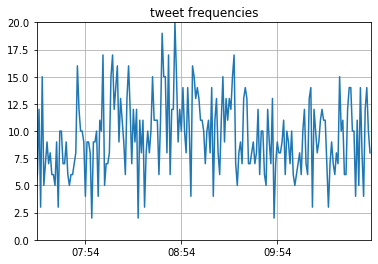

In [17]:
plt.figure(figsize=(17,14))
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=60)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
print(max_date, min_date, 'the date are ')
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [18]:
#!pip install WordCloud

In [19]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [20]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

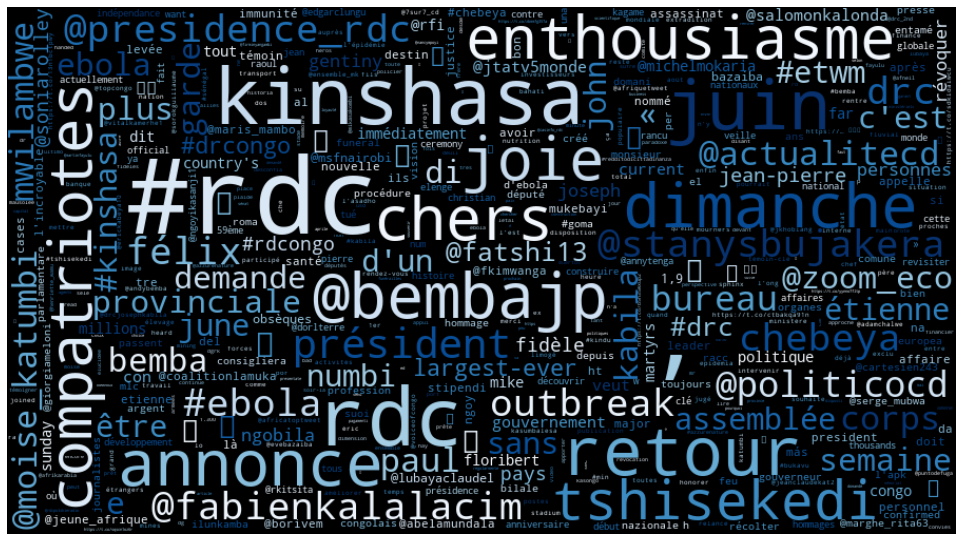

In [22]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

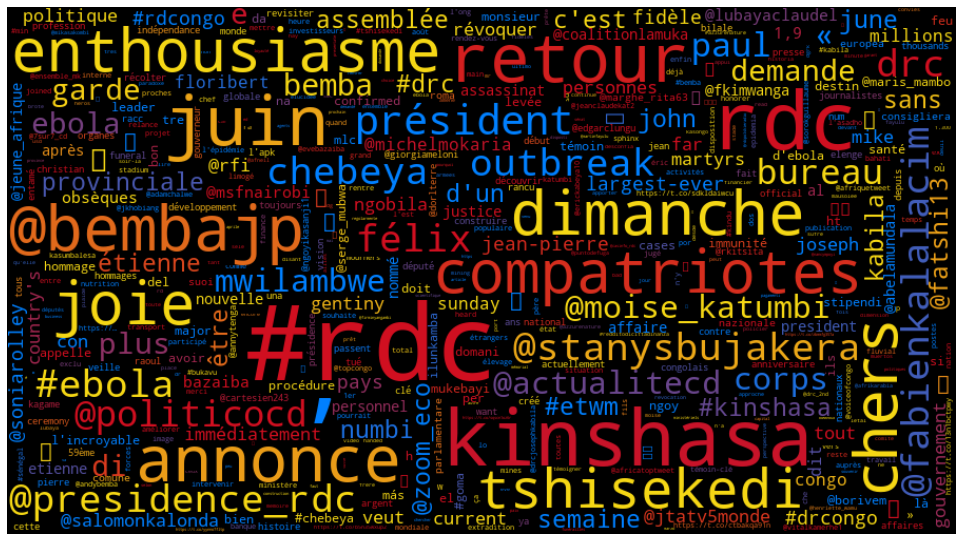

In [23]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement on twitter preprocessing 

In [24]:
import re
import preprocessor as tweet_preprocessor
import unicodedata
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [25]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3',
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', '’:'
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove = set(words_to_remove).union(emoticons)

In [26]:
len(words_to_remove)

437

let remove also the emojis

In [27]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [28]:
def remove_nonlatin(s): 
    """
    remove non ascii character but keep accent
    """
    s = (ch for ch in s
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(s)

In [29]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = ' '.join(re.findall(r'[\u0020-\u007F\u00A0-\u00FF\u0100-\u017F\u0180-\u024F]+', text))
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [30]:
# I decide to keep and hashtags
tweet_preprocessor.set_options(tweet_preprocessor.OPT.URL, 
                               tweet_preprocessor.OPT.EMOJI,
                               tweet_preprocessor.OPT.RESERVED,
                               tweet_preprocessor.OPT.EMOJI, 
                               tweet_preprocessor.OPT.SMILEY,
                               tweet_preprocessor.OPT.NUMBER, )

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [31]:
words_to_remove = words_to_remove.union(set(many_stop_words.get_stop_words('FR')))

In [32]:
words_to_remove = words_to_remove.union({'le', 'la', 'de'})

In [33]:
def get_term_count(path):
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in read_tweets_file(path):
        text = tweet_preprocessor.clean(tweet.get('text'))
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [34]:
for tag, count in get_term_count(TWEETS_PATH).most_common(15):
    print("{}: {}".format(tag, count))

rdc: 1066
kinshasa: 387
juin: 264
retour: 251
annonce: 229
@bembajp: 223
dimanche: 213
chers: 205
compatriotes: 201
joie: 201
enthousiasme: 201
tshisekedi: 180
ebola: 118
drc: 113
chebeya: 92


#### Ploting the wordcount graph again.

In [35]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.savefig('../images/DRC_WORD_COUNT.png')
    plt.axis("off")
    plt.show()

In [36]:
term_counts['ebola'] = term_counts['ebola']+ term_counts['ébola']

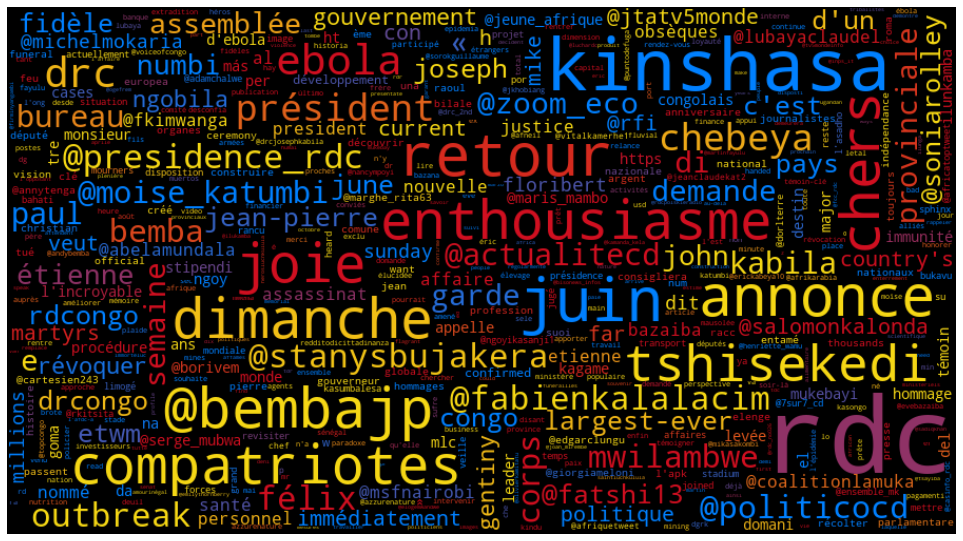

In [37]:
term_counts = get_term_count(TWEETS_PATH)
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)

In [38]:
len(term_counts)

4997

#### VI. TWITTER TOPIC MODELING

In [39]:
import spacy
from io import BytesIO
from csv import writer 
from datetime import datetime
french_stematiser = spacy.load('fr')

Basically in this phase we wil train a machine learning model on our tweet to see which topics congoleses are talking about.

we will use co-occurence of word in a tweets , if word always appear together they form a topic.

We will use also the score of a word in a given topic to find the most relevants words in a given topic.

We wiil add another preprossesing step called stemming , stemming :
    
In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm

let try spacy for stematisation.

In [40]:
#!pip install -U spacy

In [41]:
def stematise_token(tokens):
    """
    replace word in token list  with his lemma:
    example : appelais  will become appele, plural will be replaced by their singular version, etc
    """

    doc = french_stematiser(' '.join(tokens))
    return [token.lemma_ for token in doc]

let us remove other words we may find in the tweets such as congo, congolais, rdc, drc since we already knows that those words are related to congo

In [88]:
congo_words = {'congo', 'congolais', 'rdc', 'drc', '-', 'https', 'rdc', 'rdcongo', 'drc', 'drcongo', 'tshisekedi'}
words_to_remove = words_to_remove.union(congo_words)

In [89]:
re.sub(r'w{1,2}', '', '@ngoyikasanji1 @borivem @ngoyikasanji1 accorder année aller parler français ne être que un')

'@ngoyikasanji1 @borivem @ngoyikasanji1 accorder année aller parler français ne être que un'

In [90]:
def prepocess_tweet(tweet):
    """
    Apply all the preprocessing process on a tweet and return the tweet as a text and tweet as list of tokens
    
    """
    text = tweet_preprocessor.clean(tweet.get('text'))
    text = text.replace('#', '')
    #text = re.sub(r'w{1,2}', '', text) # replace all words with one or 2 char
    text = remove_emoji(text)
    tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
    tokens = stematise_token(tokens)
    return tokens

In [91]:
 def create_cleaned_df(input_path, output_path):
    """
    take an input file name of tweets , 
    cleaned them write them in a csv file and return a dataframe of cleaned tweets
    """
    output = BytesIO()
    csv_writer = writer(output)

    for tweet in read_tweets_file(input_path):
        csv_writer.writerow(tweet)
    output.seek(0) # we need to get back to the start of the BytesIO
    df = pd.read_csv(output)
    df.to_csv(output_path=output)
    return df

In [92]:
now = datetime.now()
today = now.strftime("%d-%m-%Y-%H-%M")

In [93]:
# the above function is not working but it's the most optimal https://stackoverflow.com/a/48287388/4683950
output_file_name='../data/cleanned_tweets_{}.csv'.format(today)
tweets_df = pd.DataFrame(columns=['cleanned_tweet'])
for tweet in read_tweets_file(TWEETS_PATH):
    tweets_df.loc[tweet.get('id')] = [' '.join(prepocess_tweet(tweet))]
tweets_df.to_csv(output_file_name)

In [107]:
tweets_df = pd.read_csv(output_file_name)

In [108]:
print(output_file_name)

../data/cleanned_tweets_03-06-2019-23-04.csv


In [109]:
#tweets_df = create_cleaned_df('../data/query_drc.jsonl', '../data/cleanned_tweets.csv')

In [110]:
tweets_df.set_index('Unnamed: 0', inplace=True)

In [111]:
tweets_df.dropna(inplace=True)

The next step will be to apply now the algorithm and do topic modeling 

#### VI.b. sklearn phase 

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.95 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=5, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [113]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')
transfromed_tweets = vectorizer.fit_transform(tweets_df.get('cleanned_tweet'))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-113-7314beb6c9b3>:1: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')


In [114]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [115]:
number_of_topics = 5
topic_modeling_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, max_iter=200) 

In [116]:
topic_modeling_model.fit(transfromed_tweets)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=200,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [118]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [119]:
test_string = ',@mleach_ids ongoing ebola catastrophe latest nejm article confirm drastic effects violence need f'

In [120]:
no_top_words = 10
display_topics(topic_modeling_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,être,62.7,ebola,104.1,kinshasa,261.0,assemblée,36.4,@fabienkalalacim,66.1
1,affaire,58.2,outbreak,67.2,retour,251.2,demande,36.2,@politicocd,49.0
2,paul,56.2,@presidence_rdc,61.4,juin,242.0,provincial,35.0,félix,41.2
3,kabila,49.1,bemba,48.2,annonce,229.2,bureau,33.2,etwm,39.2
4,chebeyer,45.8,june,38.2,@bembajp,223.2,kinshasa,33.1,corps,29.2
5,kinshaser,38.1,nouveau,35.2,cher,214.2,révoquer,32.2,nommer,27.2
6,témoin,36.2,country,33.2,dimanche,213.2,gentiny,32.2,mik,27.2
7,mwilambw,36.2,@zoom_eco,31.4,joie,201.2,ngobila,32.2,president,27.2
8,assassinat,33.2,current,31.2,enthousiasme,201.2,immédiatement,31.2,fidèle,27.2
9,joseph,32.2,ever,30.2,compatriote,201.2,million,25.2,kinshasa,26.5


### let us visualize the results

In [121]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(topic_modeling_model, transfromed_tweets, vectorizer, mds='tsne')
panel

/Users/espoir-mur/Projects/Personnal/twitter-analysis/.venv3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -109.817528  136.382660       1        1  27.980310
1      -52.448540 -137.800934       2        1  19.501584
0      159.692139 -320.703552       3        1  19.365278
4      178.943878  160.639786       4        1  17.605982
3      320.899597  -79.895035       5        1  15.546846, topic_info=    Category        Freq              Term       Total  loglift  logprob
672  Default  235.000000            retour  235.000000  30.0000  30.0000
153  Default  214.000000           annonce  214.000000  29.0000  29.0000
22   Default  209.000000          @bembajp  209.000000  28.0000  28.0000
217  Default  200.000000              cher  200.000000  27.0000  27.0000
282  Default  199.000000          dimanche  199.000000  26.0000  26.0000
436  Default  188.000000              joie  188.000000  25.0000  25.0000
232  Default  188.000000       compatriote  188.000000  24.0000  24.0000
321  Default  188.000000      enthousiasme  188.000000  23.0000  23.0000
445  Default  247.000000              juin  247.000000  22.0000  22.0000
456  Default  300.000000          kinshasa  300.000000  21.0000  21.0000
309  Default  133.000000             ebola  133.000000  20.0000  20.0000
43   Default   70.000000  @fabienkalalacim   70.000000  19.0000  19.0000
570  Default   70.000000          outbreak   70.000000  18.0000  18.0000
131  Default   55.000000           affaire   55.000000  17.0000  17.0000
584  Default   53.000000              paul   53.000000  16.0000  16.0000
796  Default   73.000000              être   73.000000  15.0000  15.0000
93   Default   73.000000   @presidence_rdc   73.000000  14.0000  14.0000
91   Default   60.000000       @politicocd   60.000000  13.0000  13.0000
636  Default   57.000000        provincial   57.000000  12.0000  12.0000
448  Default   55.000000            kabila   55.000000  11.0000  11.0000
195  Default   56.000000             bemba   56.000000  10.0000  10.0000
328  Default   37.000000              etwm   37.000000   9.0000   9.0000
203  Default   55.000000            bureau   55.000000   8.0000   8.0000
373  Default   52.000000             félix   52.000000   7.0000   7.0000
215  Default   53.000000          chebeyer   53.000000   6.0000   6.0000
170  Default   48.000000         assemblée   48.000000   5.0000   5.0000
267  Default   47.000000           demande   47.000000   4.0000   4.0000
446  Default   36.000000              june   36.000000   3.0000   3.0000
545  Default   31.000000           ngobila   31.000000   2.0000   2.0000
683  Default   31.000000          révoquer   31.000000   1.0000   1.0000
..       ...         ...               ...         ...      ...      ...
264   Topic5   13.507582             degré   14.258397   1.8072  -4.9690
18    Topic5   13.507581        @annytenga   14.258397   1.8072  -4.9690
12    Topic5   12.556342     @afriquetweet   13.307158   1.8032  -5.0420
737   Topic5   12.554603             total   13.307133   1.8031  -5.0422
668   Topic5   11.605105               rer   12.355919   1.7986  -5.1208
536   Topic5   11.603236            nation   12.355896   1.7985  -5.1210
354   Topic5   10.653863           finance   11.404681   1.7932  -5.2063
556   Topic5   10.653863         nutrition   11.404681   1.7932  -5.2063
8     Topic5   10.653780           @afneil   11.404680   1.7932  -5.2063
709   Topic5   10.652697          souvenir   11.404669   1.7931  -5.2064
352   Topic5   10.648019              fils   11.404598   1.7927  -5.2069
759   Topic5    9.702624               usd   10.453442   1.7868  -5.2999
187   Topic5    9.702621             banqu   10.453442   1.7868  -5.2999
599   Topic5    9.702563           plaider   10.453441   1.7868  -5.2999
159   Topic5    9.702563          approche   10.453441   1.7868  -5.2999
267   Topic5   34.466060           demande   47.442048   1.5418  -4.0323
170   Topic5   34.652154         assemblée   48

In [ ]:
topic_model_nmf = NMF(n_components=10, random_state=0, alpha=.1, l1_ratio=.5)

In [ ]:
topic_model_nmf.fit(transfromed_tweets)

In [ ]:
no_top_words = 10
display_topics(topic_model_nmf, tf_feature_names, no_top_words)

I think I have something to understand tommorrow moring ,
now I can level up on the others topics